# TMY to Power Tutorial

This tutorial will walk through the process of going from TMY data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load TMY data](#Load-TMY-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)

This tutorial requires pvlib >= 0.6.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona, July 2015, March 2016, August 2018.
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

# finally, we import the pvlib library
import pvlib

## Load TMY data

pvlib comes with a couple of TMY files, and we'll use one of them for simplicity. You could also load a file from disk, or specify a url. See this NREL website for a list of TMY files:

http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
datapath = os.path.join(pvlib_abspath, 'data', '703165TY.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.iotools.read_tmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')['2015']

The file handling above looks complicated because we're trying to account for the many different ways that people will run this notebook on their systems. You can just put a simple string path into the ``read_tmy3`` function if you know where the file is.

Let's look at the imported version of the TMY file.

In [3]:
tmy_data.head()

,Date (MM/DD/YYYY),Time (HH:MM),ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,...,AOD,AODSource,AODUncertainty,Alb,AlbSource,AlbUncertainty,Lprecipdepth,Lprecipquantity,LprecipSource,LprecipUncertainty
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:30:00-09:00,01/01/1997,01:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 01:30:00-09:00,01/01/1997,02:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 02:30:00-09:00,01/01/1997,03:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 03:30:00-09:00,01/01/1997,04:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 04:30:00-09:00,01/01/1997,05:00,0,0,0,1,0,0,1,0,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

Plot the GHI data from the TMY file

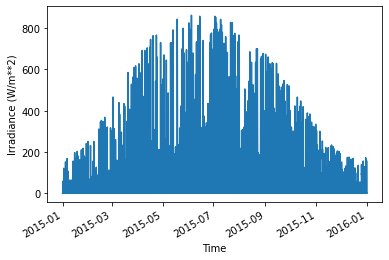

In [4]:
tmy_data['GHI'].plot()
plt.ylabel('Irradiance (W/m**2)');

## Calculate modeling intermediates

Before we can calculate power for all times in the TMY file, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

First, define some PV system parameters.

In [5]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska', 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

Location: 
  name: SAND POINT
  latitude: 55.317
  longitude: -160.517
  altitude: 7.0
  tz: US/Alaska


### Solar position

Calculate the solar position for all times in the TMY file. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

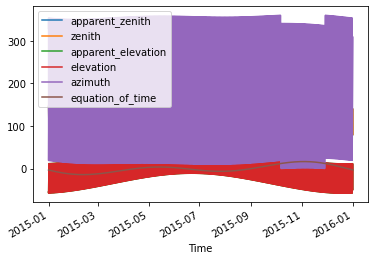

In [6]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point.latitude, sand_point.longitude)

solpos.plot();

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

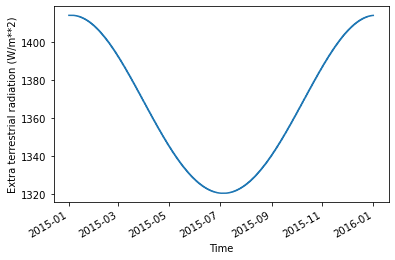

In [7]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.get_extra_radiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)');

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

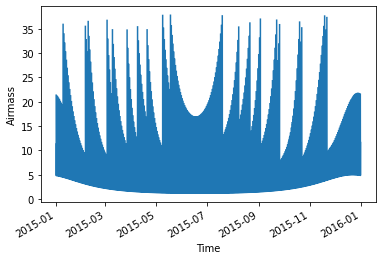

In [8]:
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass');

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

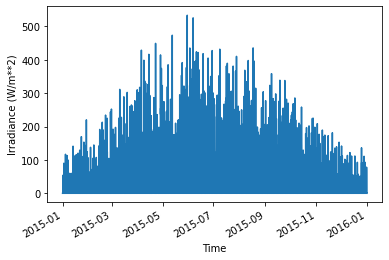

In [9]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             tmy_data['DHI'], tmy_data['DNI'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])

poa_sky_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)');

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

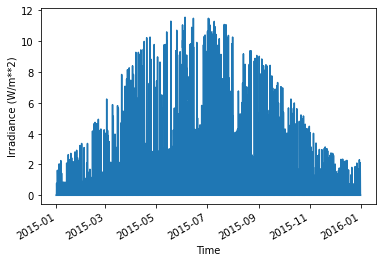

In [10]:
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(surface_tilt, tmy_data['GHI'], albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)');

### AOI

Calculate AOI

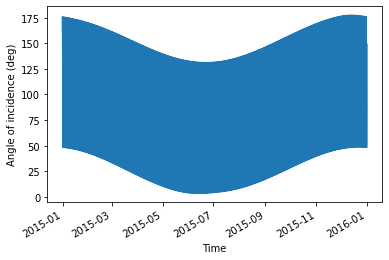

In [11]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)');

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

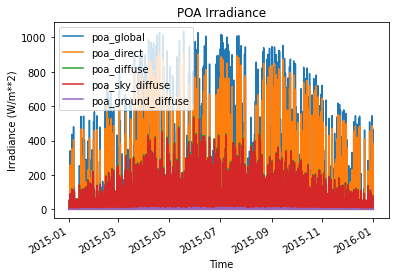

In [12]:
poa_irrad = pvlib.irradiance.poa_components(aoi, tmy_data['DNI'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance');

### Cell temperature

Calculate pv cell temperature

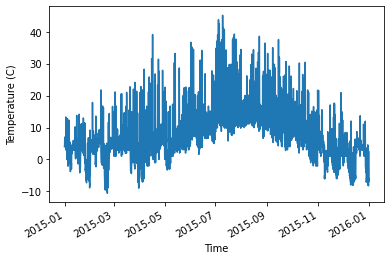

In [13]:
thermal_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemps = pvlib.temperature.sapm_cell(poa_irrad['poa_global'], tmy_data['DryBulb'], tmy_data['Wspd'], **thermal_params)

pvtemps.plot()
plt.ylabel('Temperature (C)');

## DC power using SAPM

Get module data.

In [14]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Choose a particular module

In [15]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

Calculate the effective irradiance

In [16]:
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, airmass, aoi, sandia_module)

Run the SAPM using the parameters we calculated above.

                           i_sc  i_mp  v_oc  v_mp  p_mp  i_x  i_xx
Time                                                              
2015-01-01 00:30:00-09:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 01:30:00-09:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 02:30:00-09:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 03:30:00-09:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2015-01-01 04:30:00-09:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0


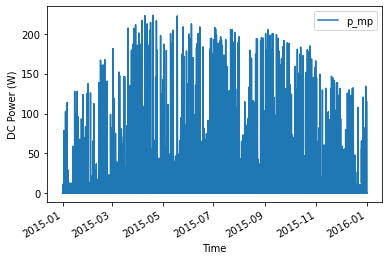

In [17]:
sapm_out = pvlib.pvsystem.sapm(effective_irradiance, pvtemps, sandia_module)
print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

## DC power using single diode

In [18]:
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules.Canadian_Solar_Inc__CS5P_220M

In [19]:
d = {k: cec_module[k] for k in ['a_ref', 'I_L_ref', 'I_o_ref', 'R_sh_ref', 'R_s']}

In [20]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvlib.pvsystem.calcparams_desoto(poa_irrad.poa_global,
                                     pvtemps,
                                     cec_module['alpha_sc'],
                                     EgRef=1.121,
                                     dEgdT=-0.0002677, **d))

In [21]:
single_diode_out = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                              resistance_series, resistance_shunt, nNsVth)

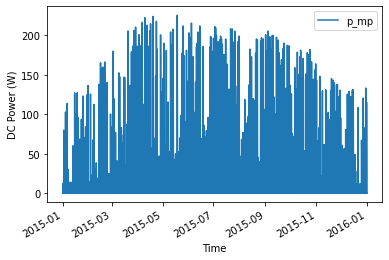

In [22]:
single_diode_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

## AC power using SAPM

Get the inverter database from the web

In [23]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [24]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
sapm_inverter

Vac                          208
Pso                      2.08961
Paco                         250
Pdco                     259.589
Vdco                          40
C0                      -4.1e-05
C1                      -9.1e-05
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                        50
Idcmax                   6.48972
Mppt_low                      30
Mppt_high                     50
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

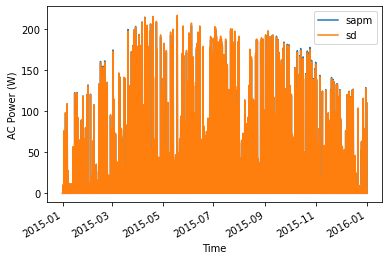

In [25]:
p_acs = pd.DataFrame()
p_acs['sapm'] = pvlib.inverter.sandia(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)
p_acs['sd'] = pvlib.inverter.sandia(single_diode_out.v_mp, single_diode_out.p_mp, sapm_inverter)

p_acs.plot()
plt.ylabel('AC Power (W)');

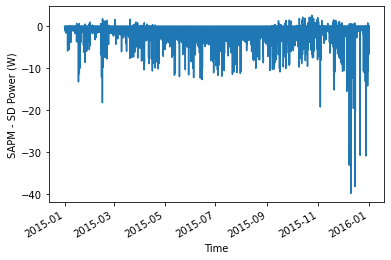

In [26]:
diff = p_acs['sapm'] - p_acs['sd']
diff.plot()
plt.ylabel('SAPM - SD Power (W)');

Plot just a few days.

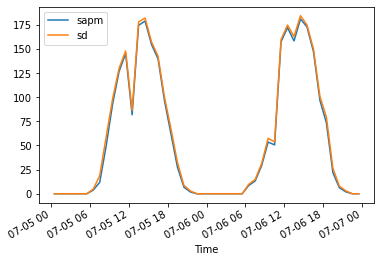

In [27]:
p_acs.loc['2015-07-05':'2015-07-06'].plot();

Some statistics on the AC power

In [28]:
p_acs.describe()

,sapm,sd
count,8760.000000,8760.000000
mean,23.214159,24.359824
std,42.869990,43.498806
min,-0.075000,-0.075000
25%,-0.075000,-0.075000
50%,-0.075000,-0.075000
75%,27.849403,30.768026
max,215.045605,217.109196


In [29]:
p_acs.sum()

sapm    203356.030218
sd      213392.055064
dtype: float64

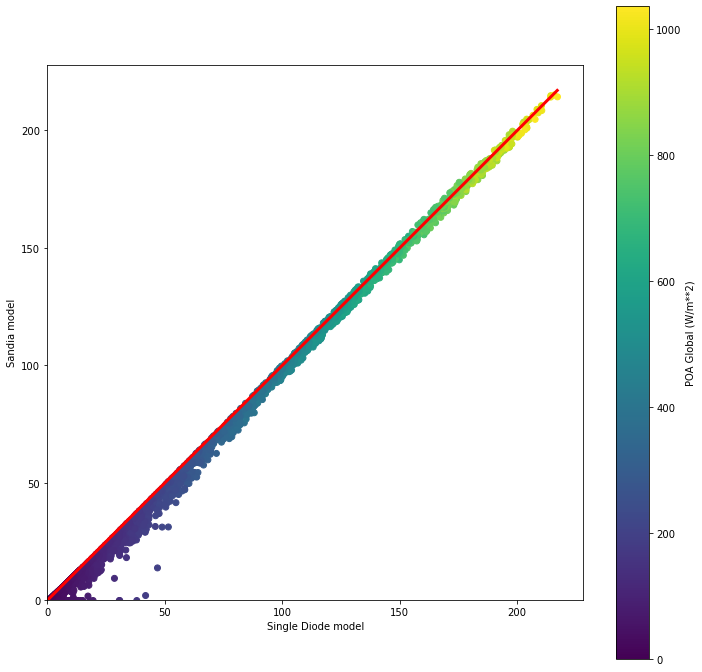

In [30]:
# create data for a y=x line
p_ac_max = p_acs.max().max()
yxline = np.arange(0, p_ac_max)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=poa_irrad.poa_global, alpha=1)  
ax.plot(yxline, yxline, 'r', linewidth=3)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel('Single Diode model')
ax.set_ylabel('Sandia model')
fig.colorbar(sc, label='POA Global (W/m**2)');

We can change the value of color value ``c`` to see the sensitivity of model accuracy to measured meterological conditions. It can be useful to define a simple plotting function for this kind of exploratory analysis.

In [31]:
def sapm_sd_scatter(c_data, label=None, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. single diode p_ac.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, aspect='equal')
    sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=c_data, alpha=1, **kwargs)  
    ax.plot(yxline, yxline, 'r', linewidth=3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('Single diode model power (W)')
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(label), shrink=0.75)
    
    return fig, ax

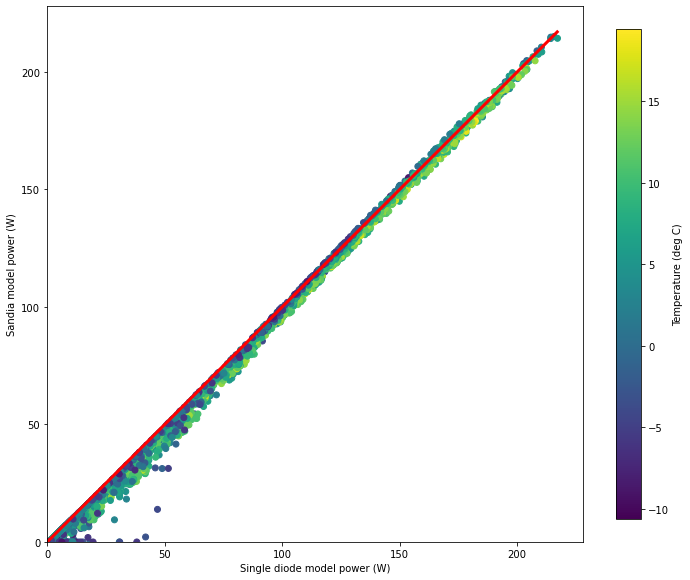

In [32]:
sapm_sd_scatter(tmy_data.DryBulb, label='Temperature (deg C)');

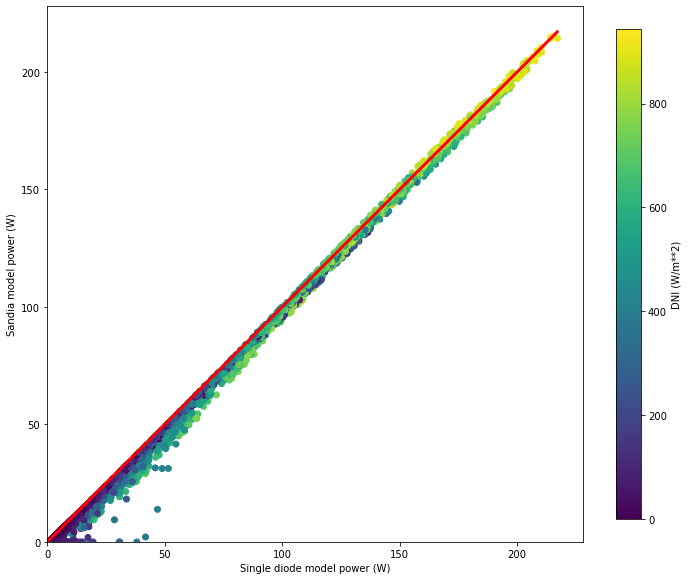

In [33]:
sapm_sd_scatter(tmy_data.DNI, label='DNI (W/m**2)');

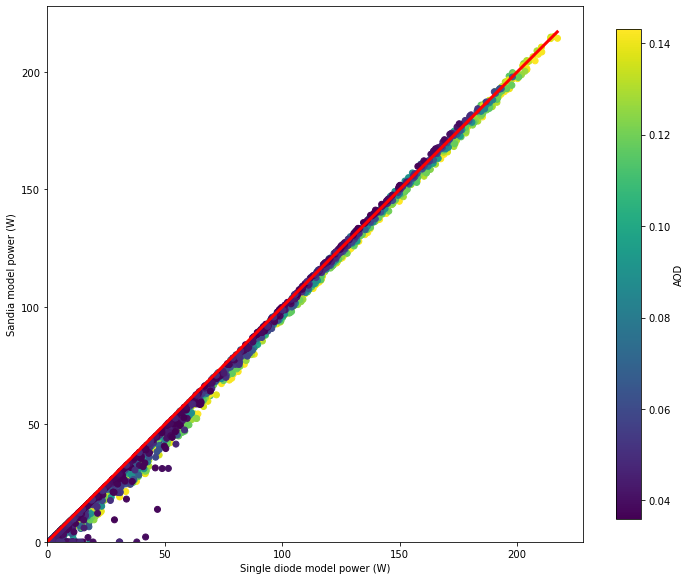

In [34]:
sapm_sd_scatter(tmy_data.AOD, label='AOD');

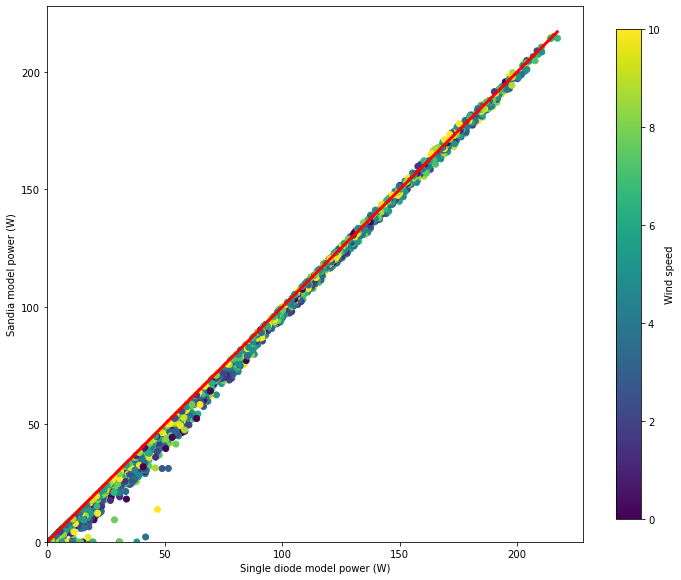

In [35]:
sapm_sd_scatter(tmy_data.Wspd, label='Wind speed', vmax=10);

Notice the use of the ``vmax`` keyword argument in the above example. The ``**kwargs`` pattern allows us to easily pass non-specified arguments to nested functions.

In [36]:
def sapm_other_scatter(c_data, x_data, clabel=None, xlabel=None, aspect_equal=False, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. something else.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
    x_data : array-like
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    
    if aspect_equal:
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.add_subplot(111)
    sc = ax.scatter(x_data, p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(clabel), shrink=0.75)
    
    return fig, ax

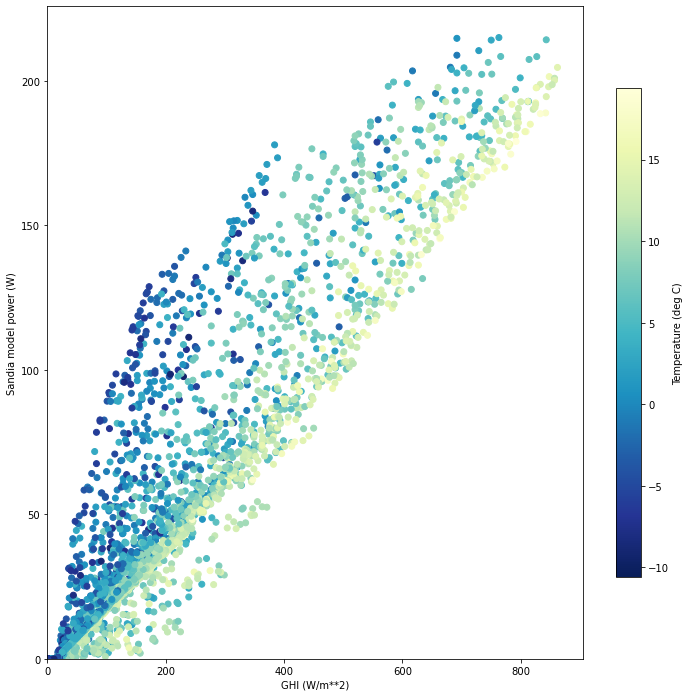

In [37]:
sapm_other_scatter(tmy_data.DryBulb, tmy_data.GHI, clabel='Temperature (deg C)', xlabel='GHI (W/m**2)');

Next, we will assume that the SAPM model is representative of the real world performance so that we can use scipy's optimization routine to derive simulated PVUSA coefficients. You will need to install scipy to run these functions.

Here's one PVUSA reference:

http://www.nrel.gov/docs/fy09osti/45376.pdf


In [38]:
def pvusa(pvusa_data, a, b, c, d):
    """
    Calculates system power according to the PVUSA equation
    
    P = I * (a + b*I + c*W + d*T)
    
    where
    P is the output power,
    I is the plane of array irradiance,
    W is the wind speed, and
    T is the temperature
    
    Parameters
    ----------
    pvusa_data : pd.DataFrame
        Must contain the columns 'I', 'W', and 'T'
    a : float
        I coefficient
    b : float
        I*I coefficient
    c : float
        I*W coefficient
    d : float
        I*T coefficient
    
    Returns
    -------
    power : pd.Series
        Power calculated using the PVUSA model.
    """
    return pvusa_data['I'] * (a + b*pvusa_data['I'] + c*pvusa_data['W'] + d*pvusa_data['T'])

In [39]:
from scipy import optimize

In [40]:
pvusa_data = pd.DataFrame()
pvusa_data['I'] = poa_irrad.poa_global
pvusa_data['W'] = tmy_data.Wspd
pvusa_data['T'] = tmy_data.DryBulb

In [41]:
popt, pcov = optimize.curve_fit(pvusa, pvusa_data.dropna(), p_acs.sapm.values, p0=(.0001,0.0001,.001,.001))
print('optimized coefs:\n{}'.format(popt))
print('covariances:\n{}'.format(pcov))

optimized coefs:
[ 2.08877712e-01  9.94996955e-06  9.81779437e-04 -1.38247699e-03]
covariances:
[[ 1.37624634e-07 -1.00057042e-10 -8.03579294e-09 -2.38036259e-09]
 [-1.00057042e-10  1.92677501e-13 -7.89149981e-13 -2.57386028e-12]
 [-8.03579294e-09 -7.89149981e-13  1.28519705e-09  1.96643964e-10]
 [-2.38036259e-09 -2.57386028e-12  1.96643964e-10  3.86946463e-10]]


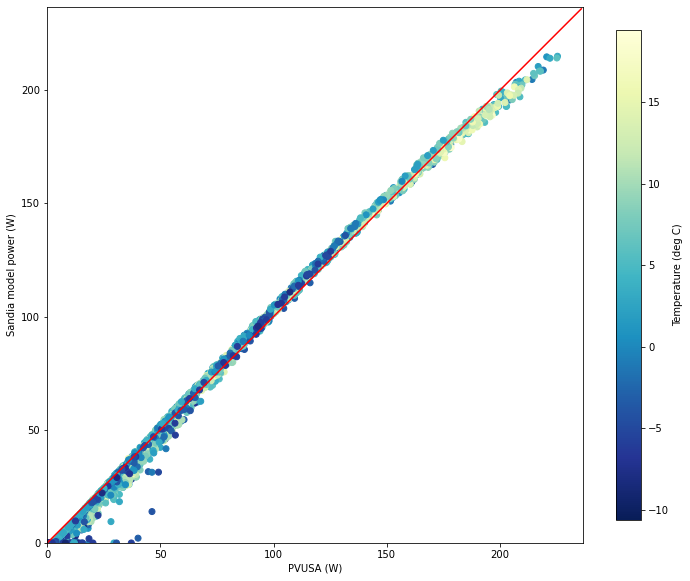

In [42]:
power_pvusa = pvusa(pvusa_data, *popt)

fig, ax = sapm_other_scatter(tmy_data.DryBulb, power_pvusa, clabel='Temperature (deg C)',
                             aspect_equal=True, xlabel='PVUSA (W)')

maxmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_ylim(None, maxmax)
ax.set_xlim(None, maxmax)
ax.plot(np.arange(maxmax), np.arange(maxmax), 'r');